In [1]:
import os
import torch
import torch.utils.data as torchdata
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm
import torch.optim as optim
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import argparse
from torch.autograd import Variable
# from tensorboard_logger import configure, log_value
from torch.distributions import Bernoulli

from utils import utils, utils_detector
from constants import base_dir_metric_cd, base_dir_metric_fd
from constants import num_actions

import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torchvision.transforms as transforms

# GPU Device
gpu_id = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
use_cuda = torch.cuda.is_available()
print("GPU device " , use_cuda)

GPU device  True


In [115]:
num_actions = 4
pt_model = 'model2.pth'

# Image Load

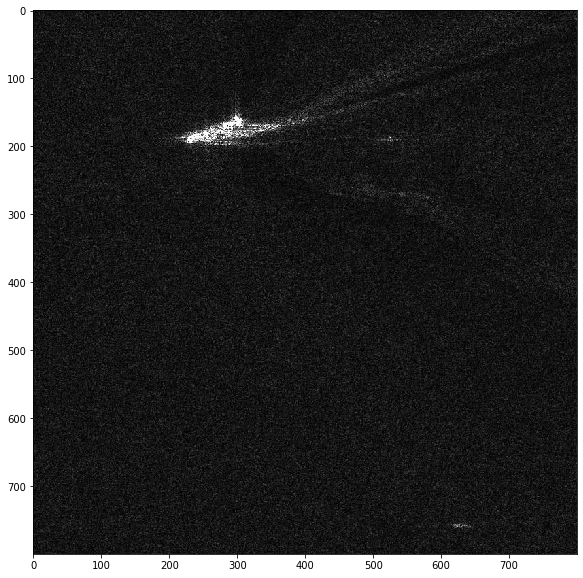

In [116]:
# load image sample
img_dir = '/media/data2/dataset/SSDD/800/test/img/P0137_109.jpg'
target_dir = '/media/data2/dataset/SSDD/800/test/img/'
img = Image.open(img_dir)
plt.figure(figsize=(10,10))
plt.imshow(img)
img_size = 256
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform_test = transforms.Compose([
        transforms.Scale(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

# Pre-trained model load

In [117]:
trainset, testset = utils.get_dataset(256, './data/800/')
agent = utils.get_model(num_actions)
load_model = torch.load(pt_model)
agent.load_state_dict(load_model['agent'])

<All keys matched successfully>

In [118]:
inputs = transform_test(img).cuda().unsqueeze(0)
agent = agent.cuda().eval()

In [119]:
# inputs = i[0].cuda()

In [120]:
# Actions by the Policy Network
probs = F.sigmoid(agent(inputs))

# Sample the policy from the agents output
policy = probs.data.clone()
policy[policy<0.5] = 0.0
policy[policy>=0.5] = 1.0
policy = Variable(policy)

In [121]:
print(probs)
print(policy)

tensor([[1.0243e-05, 5.4181e-05, 7.3823e-06, 4.7311e-06]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[0., 0., 0., 0.]], device='cuda:0')


# Chosen Policy Visualization

<Figure size 432x288 with 0 Axes>

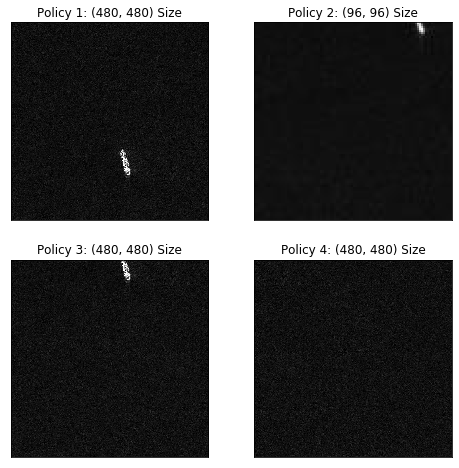

In [105]:
img1 = Image.open('/media/data2/dataset/SSDD/800/test/480/img/P0004_4200_5000_2400_3200_0.jpg')
img2 = Image.open('/media/data2/dataset/SSDD/800/test/96/img/P0004_4200_5000_2400_3200_1.jpg')
img3 = Image.open('/media/data2/dataset/SSDD/800/test/480/img/P0004_4200_5000_2400_3200_2.jpg')
img4 = Image.open('/media/data2/dataset/SSDD/800/test/480/img/P0004_4200_5000_2400_3200_3.jpg')
img1_size = img1.size
img2_size = img2.size
img3_size = img3.size
img4_size = img4.size

fig = plt.figure()
fig, ax_lst = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    for j in range(2):
        ax_lst[i][j].set_xticks([])
        ax_lst[i][j].set_yticks([])
ax_lst[0][0].set_title('Policy 1: {} Size'.format(img1_size))
ax_lst[0][0].imshow(img1)
ax_lst[0][1].set_title('Policy 2: {} Size'.format(img2_size))
ax_lst[0][1].imshow(img2)
ax_lst[1][0].set_title('Policy 3: {} Size'.format(img3_size))
ax_lst[1][0].imshow(img3)
ax_lst[1][1].set_title('Policy 4: {} Size'.format(img4_size))
ax_lst[1][1].imshow(img4)
plt.show()

# Bounding Box from YOLO

In [106]:
target1 = np.load('data/800/base_dir_detections_fd/P0004_4200_5000_2400_3200_0_0.npy').squeeze()
target2 = np.load('data/800/base_dir_detections_cd/P0004_4200_5000_2400_3200_0_1.npy').squeeze()
target3 = np.load('data/800/base_dir_detections_fd/P0004_4200_5000_2400_3200_1_0.npy').squeeze()
target4 = np.load('data/800/base_dir_detections_fd/P0004_4200_5000_2400_3200_1_1.npy').squeeze()
bbox1_1, bbox1_2, bbox2_1, bbox2_1, bbox3_1, bbox3_2, bbox4_1, bbox4_2 = [], [], [], [], [], [], [], []

In [107]:
if len(target1) > 0:
    bbox1_1, bbox1_2 = (int(target1[0]), int(target1[1])), (int(target1[2]), int(target1[3]))
    img1 = cv2.rectangle(np.array(img1), bbox1_1, bbox1_2, (255,0,0), 3)
if len(target2) > 0:
    bbox2_1, bbox2_2 = (int(target2[0]), int(target2[1])), (int(target2[2]), int(target2[3]))
    img2 = cv2.rectangle(np.array(img2), bbox2_1, bbox2_2, (255,0,0), 3)
if len(target3) > 0:
    bbox3_1, bbox3_2 = (int(target3[0]), int(target3[1])), (int(target3[2]), int(target3[3]))
    img3 = cv2.rectangle(np.array(img3), bbox3_1, bbox3_2, (255,0,0), 3)
if len(target4) > 0:
    bbox4_1, bbox4_2 = (int(target4[0]), int(target4[1])), (int(target4[2]), int(target4[3]))
    img4 = cv2.rectangle(np.array(img4), bbox4_1, bbox4_2, (255,0,0), 3)

<Figure size 432x288 with 0 Axes>

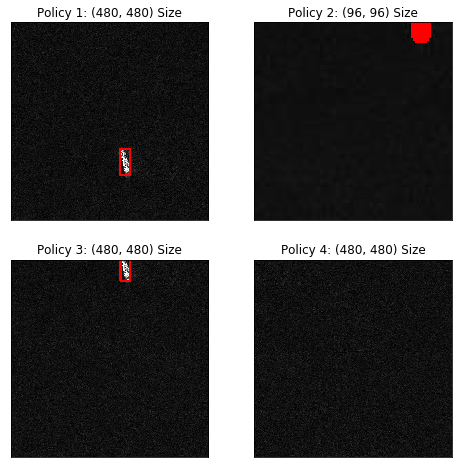

In [108]:
fig = plt.figure()
fig, ax_lst = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    for j in range(2):
        ax_lst[i][j].set_xticks([])
        ax_lst[i][j].set_yticks([])
ax_lst[0][0].set_title('Policy 1: {} Size'.format(img1_size))
ax_lst[0][0].imshow(img1)
ax_lst[0][1].set_title('Policy 2: {} Size'.format(img2_size))
ax_lst[0][1].imshow(img2)
ax_lst[1][0].set_title('Policy 3: {} Size'.format(img3_size))
ax_lst[1][0].imshow(img3)
ax_lst[1][1].set_title('Policy 4: {} Size'.format(img4_size))
ax_lst[1][1].imshow(img4)
plt.show()